## 1. Introduction {-}

VQAs (Variational Quantum Algorithms) is a group of hybrid quantum-classical algorithms, specially designed to exploit the power of quantum computation even in the current reality of noisy quantum devices.
As VQE (Variational Quantum Eigensolver) is the first and most "fundamental" VQA - this work pursues the following question: how does quantum noise affect the performance of the VQE algorithm?

My research presented in this work is mainly based on the paper - "The Effect of Noise on the performance of Variational Algorithms for Quantum Chemistry" by *Saib et al.* [1], though this work extends the research described in [1] and provides some few additional insights.

This paper is not a formal scientific paper but rather a personal research project - therefore some aspects are given much focus while other aspects are discussed briefly. A particular emphasis is given to the practical aspect, with a fully available Qiskit implementation of the research described throughout this work in a detailed manner.

In section 2, I begin with a brief overview of the necessary background needed as a prerequisite for this work. In section 3, the methodology of the research (which is partially based on the methodology conducted in [1]) is described, and a quick description of the chosen benchmarks is given. Then a Qiskit implementation of the experiment depicted in [1] is presented in section 4. In section 5, an extension of the experiment is introduced, along with new insights. Unlike in [1], a clear correlation between the noise level associated with a particular ansatz to the quality of results is found. In addition, an implementation of a noise characterization technique which might be of particular usefulness to VQAs is being suggested.

## 2. Motivation, Prerequisites and a Brief Overview {-}

Today's quantum computers are affected heavily by quantum noise [2]. In fact, today's quantum devices are noisy enough to be given a special name - NISQ [3] (Noisy Intermediate Scale Quantum) computers. Due to quantum noise, most known quantum algorithms are intractable for the NISQ devices, certainly at scale. For example, the 2 most famous quantum algorithms, i.e Shor's [4] and Grover's [5] algorithms - are in fact infeasible for NISQ devices (excluding some very small-scale proof-of-concept implementations - such as factoring the number 15 using Shor's algorithm with a quantum computer). In order to fully exploit the power of quantum computation we need a fault-tolerant quantum computer [6] - i.e a quantum computer with the sufficient hardware and software stack to perform quantum error-correction [7] (among some other things). While tremendous efforts are invested worldwide in the race for building such a machine, and indeed significant improvements in both quantum hardware and software took place in recent years - a full-scale fault-tolerant quantum computer is still far away.

However, still there is a place for hope to real-world quantum applications in the near term, i.e before reaching the "promised land" of fault-tolerant quantum computers. But before we dive into that, a short and very general description of the quantum noise phenomenon is needed. Quantum noise can take many forms and is generated from multiple sources - while 2 main "families" of quantum noise are decoherence [8] and gate-errors accumulation [9]. In a nutshell, decoherence evolves in a quantum system due to interactions of the system with the environment, leading to a loss of the quantum properties of the system. Gate-errors are somewhat more straight-forward - when applying some quantum logic gate to a system of qubits in initial state $|\psi_0\rangle$, we expect a certain evolution of the quantum state to another state $|\psi_1\rangle$. In practice, the involvement of a certain error rate in that evolution is inevitable, causing $|\psi_0\rangle$ to evolve to a somewhat different state than we would have expected. This type of gate error is also called "coherent noise". "Gate-errors accumulation" is a term that refers to the accumulation of the errors caused by all the gates in the quantum circuit. Being more strict, gate errors can also stem from interaction with the environment ("incoherent noise"). Thus, if we could devise quantum algorithms that employ quantum circuits that are "small" enough - both in gate count and circuit depth - we might evade some of the calamitous consequences caused by the quantum noise phenomena described above.

Algorithms of the group called VQAs [10] (Variational Quantum Algorithms) are based on a classical-quantum hybrid design, which makes small quantum circuits applicable to practical problems. Generically speaking, the idea is based on a shallow parameterized quantum circuit design (called ansatz)[10] consisting of quantum parameterized gates, combined with a classical computation scheme. The role of the ansatz is to engage the part of the problem that is intractable for a classical computer (i.e with a complexity that grows exponentially with respect to the input size). The parameters of the ansatz's gates are tuned by a classical optimizer, according to the outcomes of the quantum measurements. The whole process is repeated iteratively until convergence.

The first, and most known variational quantum algorithm is the VQE [11] (Variational Quantum Eigensolver). This paper focuses solely on the VQE as a benchmark for the whole VQA group. Generically speaking again, I provide here a concise but necessary brief of the VQE's functionality. Given a Hamiltonian operator decomposed to a sum of Pauli strings (it is soon demonstrated), the VQE provides an approximation for its ground state energy. Such computation can be performed classically by diagonalization of the Hamiltonian matrix, which is efficient with respect to the dimensions of the matrix, but since the dimensions of the Hamiltonian matrix grow exponentially with the size of the quantum system - this problem is exponentially hard for classical computers.

The way VQE works is as follows: A trial state $|\psi({\vec{\theta})}\rangle$ is being prepared by tuning the $k$ parameters of the ansatz ($\vec{\theta}$ is just a vector that stores the $k$ parameters, $\vec{\theta} = \begin{bmatrix}\theta_0 & \theta_1 & ... & \theta_{k-1}\end{bmatrix}$). The Hamiltonian matrix (denoted $H$) is Hermitian, and therefore can be regarded as an observable in a quantum system. The expectation value of $H$ with respect to the prepared state $|\psi({\vec{\theta})}\rangle$ is $\langle H \rangle_{\psi} = \langle\psi(\vec{\theta})|H|\psi(\vec{\theta})\rangle$. The smallest eigenvalue of any Hamiltonian is its ground state energy $E_0$, so we obtain the following important equation:

$$ \langle\psi(\vec{\theta})|H|\psi(\vec{\theta})\rangle \ge E_0$$.

The goal is to compute the closest possible value to $E_0$. But how would one even measure $H$? For that it's necessary to decompose $H$ to Pauli strings. It turns out that the set of the Pauli matrices + the identity matrix $S_1 = \{I, X, Y, Z\}$ forms a basis for the vector space of all $2 \times 2$ Hermitian matrices. In a similar manner, the generic set $S_n = \{I, X, Y, Z\}^n$ (i.e $S_n$ consists of all the possible n-length tensor products of $S_1$ elements = "Pauli strings") forms a basis for the vector space of all $2^n \times 2^n$ Hermitian matrices. Since any Hermitian matrix may serve as a Hamiltonian, now we can write $H$ as a sum of Pauli strings: $H=\sum_i \alpha_i P_i$, while $\alpha_i$ are real coefficients and $P_i$ are the Pauli strings.

Gate-based quantum computers can (in principle) measure directly only the $Z$ observable. It's possible though to apply a certain rotation to the quantum state just before the measurement in order to measure the $X$ or $Y$ observables - remember that the Pauli $X, Y, Z$ matrices share their eigenvalues - which are $\{+1,-1\}$. Their corresponding eigenstates are: $\{|0\rangle, |1\rangle\}$ for the $Z$ operator, $\{|+\rangle, |-\rangle\}$ for the $X$ operator and $\{|+i\rangle, |-i\rangle\}$ for the $Y$ operator. Therefore, regarding measurements of single qubits - an $X$-basis measurement consists of applying $R_y(-\frac{\pi}{2})$ rotation followed by a (standard) $Z$-basis measurement. Following the same logic, a $Y$-basis measurement consists of applying $R_x(\frac{\pi}{2})$ rotation followed by a (standard) $Z$-basis measurement. The identity operator $I$ never changes states and therefore it has a single eigenvalue which is $+1$.

As a consequence, If $H$ is decomposed into $t$ Pauli terms, $t$ "quantum modules" are being executed in each iteration of the VQE, while each quantum module consists of the ansatz "glued" with the appropriate measurement scheme for each Pauli term. The expectation values measured in each quantum module are (classically) added, now forming an approximation for $E_0$. The classical optimizer sets a new $\vec{\theta}$ and the whole process should repeat itself up to a defined amount of iterations or until convergence.

It is necessary that $H$ decomposes efficiently to Pauli terms (If an efficient VQE is what we desire), with respect to the number of qubits $n$. Not all Hamiltonians obey this demand, but many do - and they form a subset that is relevant for VQEs.

## 3. Methodology {-}

As in [1], this work deals with and looks into some of the VQE's properties, certainly not all of them. This section describes the scope of the work and the chosen benchmarks.

The Hydrogen molecule ($H_2$) is chosen in [1] as the system of interest and so is in this work. The process of mapping [12] the physical structure problem ("molecular Hamiltonian") of the $H_2$ molecule to a qubit Hamiltonian is discussed briefly in section 4, but in principle it is out of the scope of this work. Nevertheless, the implementation presented in section 4 is flexible and can handle any qubit Hamiltonian as an input - something which is not used in this work, as aforementioned.

There are a few options for classical optimizers to be incorporated into the VQE routine. This work uses strictly the SPSA optimizer [13][14], as in [1]. 200 is chosen as the number of iterations to be performed by the classical SPSA optimizer in each VQE-iteration, also as in [1].

Regarding the choice of ansatzes, the common paradigm suggests a division of the ansatz types into 2 main groups - problem-oriented ansatzes and hardware-efficient ansatzes [10][11]. A quantum system of $n$ qubits spans a Hilbert space of dimension $2^n$ - somewhere in that Hilbert space "resides" the seeked-for quantum state (i.e, the ground state, which is an eigenstate of the Hamiltonian $H$ with the smallest eigenvalue, that is the ground state energy $E_0$). Problem-oriented ansatzes ask to narrow the searches to a specific subspace of the Hilbert space, using some prior knowledge of the problem. However, this process turned out (so far) to be costly in the number of gates and circuit depth, and therefore affected substantially by quantum noise.
Hardware-efficient ansatzes are built in a "hardware-friendly" manner which produces much less noise, but without a focus on a specific subspace of the Hilbert space. This work deals with hardware-efficient ansatzes only, as in [1].

Furthermore, hardware-efficient ansatzes are built in a pattern of iterative rotation-gates blocks followed by entangling-gates blocks. Theoretically, one would want to maximize the number of iterations over these block patterns in order to span a subspace largest as possible of the solutions Hilbert space. However, due to the noisy nature of current quantum devices already discussed, deep quantum circuits are practically inapplicable for now and would produce completely stochastic results after a certain amount of evolution time. It has been shown numerically and experimentally in [13][15], and therefore this work looks into ansatz circuits with a depth of 1 iteration, except for one ansatz comprised of 2 iterations. For the sake of emphasis, here is the scheme of ansatz 29 (discussed in section 5), the only one consists of 2 iterations:

![ansatz 29 scheme](images/ansatz_29.png)

It can be seen easily that each entanglement block (combination of $CNOT$ gates) is wrapped with blocks of single-qubit parameterized rotation gates.

The implementation of the experiment presented in this work is written in Qiskit. Qiskit Nature [16] and PyQuante [17] packages are used to obtain a qubit Hamiltonian operator for the Hydrogen $H_2$ molecule. As detailed in section 4, the experiment is performed using classical simulators, in both ideal noiseless terms and using various noisy simulated backends. The noisy simulated backends imitate the properties of real quantum computers as they were in a certain instant in time (by taking a "screenshot" of a device's characterization data), excluding some sort of unsimulated errors (e.g cross-talk errors). Data processing, manipulation and graphing have been performed using the Python packages Pandas[18] and Matplotlib[19].

## 4. Experiment Implementation {-}

All code, data and details of the experiment's implementation are discussed in appendix [[A]](#Appendix_A) - in addition to a full availability of the content in a GitHub repository, also referenced from appendix [[A]](#Appendix_A).

A class named `VQE_NoiseExp` (found in `core.py` module) was written with the goal of easily creating suitable objects for the experiment depicted in [1] as a basis, with a convenient interface for possible expansions of the experiment (as being done in this work). The module `hamiltonians.py` contains the setting of the Hydrogen $H_2$ Hamiltonian and is easily expandable with more Hamiltonians definitions as well - See more in appendix [[A]](#Appendix_A). In order to keep the discussion coherent and fluent, most of the implementation details are abstracted away from the main body of this paper, while a full usage guide through the interface is provided in the rest of this work.

Therefore to initiate an experiment one shall begin by importing the following objects:

In [1]:
from core import VQE_NoiseExp
from hamiltonians import H_2_hamiltonian, H_2_NRE

As aforementioned, the exact manner of obtaining the qubit Hamiltonian of the Hydrogen $H_2$ molecule is out of this work's scope, yet the general implementation method can be found in appendix [[A]](#Appendix_A). However, before diving into the experiment, let's have a look at the Pauli decomposition of the Hydrogen $H_2$ qubit Hamiltonian, denoted as $H$:

In [2]:
print(f"H = {H_2_hamiltonian}")

H = -0.8105479965981812 * IIII
+ 0.1721839435195097 * IIIZ
- 0.22575350027942803 * IIZI
+ 0.17218394351950977 * IZII
- 0.22575350027942806 * ZIII
+ 0.120912633445247 * IIZZ
+ 0.1689275406336891 * IZIZ
+ 0.04523280037093535 * YYYY
+ 0.04523280037093535 * XXYY
+ 0.04523280037093535 * YYXX
+ 0.04523280037093535 * XXXX
+ 0.16614543381618235 * ZIIZ
+ 0.16614543381618235 * IZZI
+ 0.17464343496147006 * ZIZI
+ 0.120912633445247 * ZZII


`H_2_Hamiltonian` is a `PauliSumOp` object. This specific Hamiltonian is constructed from the Hydrogen $H_2$ molecule, but one can construct also arbitrary Hamiltonians manually by combining `PauliOp` objects, as explained in appendix [[A]](#Appendix_A).

It can be seen above that $H$ is expressed as a weighted sum of Pauli strings, and thus it is applicable for the VQE algorithm, following the method described in section 2.

Equipped with this qubit Hamiltonian, let's initialize an experiment:

In [3]:
# Creating a `VQE_NoiseExp` object
exp_1 = VQE_NoiseExp(H=H_2_hamiltonian, name="H_2_hamiltonian_exp_1", NRE=H_2_NRE)

`H_2_NRE` is the Nuclear Repulsion Energy of the Hydrogen $H_2$ molecule - It can be regarded as an intrinsic property of the molecule, computed automatically by the `hamiltonians.py` module. The NRE is a necessary detail for computing the ground state energy of a molecule - it is being added to the smallest eigenvalue of the qubit Hamiltonian $H$, and the sum yields the ground state energy.

Since the qubit Hamiltonian $H$ of the Hydrogen $H_2$ molecule is of (relatively small) $16 \times 16$ dimensions, it is easy and quick to compute its ground state energy classically. That is performed automatically for the given Hamiltonian in the construction of each `VQE_NoiseExp` object, and stored in the attribute `exact_min_ev`. Therefore by accessing `exp_1.exact_min_ev` the exact ground state energy of the Hydrogen $H_2$ molecule is obtained, which is $E_0 = -1.1373$ Hartree.

The experiment depicted in [1] examines 12 hardware-efficient ansatz circuits, numbered from 1 to 12. Their diagrams appear in [1]'s appendix and also in appendix [[B]](#Appendix_B) of this paper. Those 12 ansatzes are automatically initialized with the creation of a `VQE_NoiseExp` object as a class attribute, accessed by `VQE_NoiseExp.circuits_ob` (indexed from 1 to 12). In fact, 32 ansatz circuits are created by initialization of a `VQE_NoiseExp` object, while the extra 20 ansatz circuits are discussed in the next section of this work.

To run experiments one needs to use the `VQE_NoiseExp.run_vqe_circuits` method. By running the following command the experiment's results data will be written into a unique CSV file:

In [4]:
from qiskit import Aer

exp_1.run_vqe_circuits(circuits_ids=[i for i in range (1,13)], backend=Aer.get_backend('aer_simulator'), process_iters=5)

In the command above the chosen backend is the ideal noiseless Aer simulator, and also the parameter `process_iters` has been set to 5 - which tells the program to run the VQE algorithm 5 times for each ansatz (it's not obligatory, and the default value set by the program is 1 - however the VQE is a probabilistic algorithm ultimately, so it makes sense to iterate over the process for obtaining higher accuracy - with the expense of an additional computational cost, of course). 2 more arguments that aren't shown above are `optimizer_iters=200` (iterations of the classical SPSA optimizer, default is 200) and `csv_file=None` (One can specify a specific path for the output CSV file, otherwise the program saves the file into the `data` folder, with a unique generated name).

The results obtained by running the command above (60 records total) were written into a CSV file, which now we parse using another method of the `VQE_NoiseExp` class, that is `VQE_NoiseExp.csv_data_to_table`. This method selects the best-obtained results for each ansatz and returns a Pandas `DataFrame` object of the results' summerize. So by running the following command:

In [5]:
df1 = exp_1.csv_data_to_table(csv_file="data/1667151721.8489265_VQE_NoiseExp_results_H_2_hamiltonian_exp_1_aer_simulator_5_200.csv", caption='Ranking of Ansatzes by Performance <br /> Aer simulator (noiseless)')

# df1['df'] is a `DataFrame` object
# df1['df_styler'] is a `Styler` object of df1['df']

df1['df_styler']

We get the results in a table, ordered from the best (least energy difference compared to the exact ground state enrgy) to the worst. We, therefore, compare the results obtained in this work (left) to the data obtained in [1] (right), side by side (GSE = Ground State Energy):

![Noise simulations of ansatzez 1-12 in this work VS [1]](images/fig1_resized1.png)

It is highly recommended to examine ansatz circuits 1-12 in appendix [[B]](#Appendix_B) for the results above to be meaningful.

It can be seen that our results are of the same order of magnitude as the results obtained in [1], though not identical. The variance in the results makes sense, due to the stochastic nature of the VQE algorithm, combined with the fact that in this work each ansatz is sampled 5 times, while in [1] the number of samples per ansatz is not stated.

In addition, one can clearly notice that ansatz 10 performs very badly both in this work and in [1], and that is probably due to its lack of expressibility [20] - which is, generically speaking - a measure of the ability of an ansatz to span the Hilbert space of the solutions. In [1] it has been found that the correlation between expressibility and performance of a given ansatz is weak so this work doesn't address the expressibility measure, in general. Nevertheless, it is pretty clear that an ansatz circuit with very low expressibility won't perform well, and that is probably the case with ansatz 10. In the analysis and graphs to come, ansatz 10 is omitted due to its very large deviation which "corrupts" the graphs.

Using the same method as demonstrated above, we now simulate VQE with ansatz circuits 1-12 on noisy simulator backends - namely `FakeMelbourneV2, FakeVigoV2, FakeOurenseV2, FakeValenciaV2, FakeAthensV2`, and `FakeSantiagoV2`. Again, for each ansatz and backend combination 5 samples are taken, and the best sample is chosen for each combination. Plotting of the results of all backends combined on the same graph yields:

![VQE simulations with ansatzes 1-12 simulations on noisy backends](images/all_backends_1_12_S.png)

Some interesting insights can be deduced from this graph. Circuits 1-12 can be grouped into 2 types - circuits 1-8 exhibit a sort of "circular" entanglement pattern that consists of 4 $CNOT$ gates, while circuits 9-12 exhibit a so-called "full" entanglement pattern consists of 6 $CNOT$ gates. it is worth mentioning that these gate counts are with respect to the raw, untranspiled circuits - the transpiled entanglement patterns are in general deeper, due to the character of each device's qubits connectivity ($SWAP$ gates are added in order to entangle 2 unconnected qubits, and each $SWAP$ gate is implemented using 3 $CNOT$ gates).

While circuits 1-8 provide roughly similar deviations from the real ground state energy $E_0$, circuits 9-12 perform significantly worse. That's of course in contrast to the noiseless simulation case. Interestingly, the results obtained in this work implies on systematic inferiority in the performance of circuits 9-12 compared to circuits 1-8 - while in the research appears in [1] that's not the case. The reasons for this might be the number of samples taken for each combination of ansatz and backend, or maybe a variancy of noise models ([1] also uses "screenshot" noise models of the same IBMQ backends, but probably there is a variance in properties compared to the noise models used in this work).

However, this form of a clear correlation between circuit depth + $CNOT$ gates count to the VQE's performance drives motivation for a further study in this direction, which is discussed in the next section.

## 5. Expanding The Experiment {-}

As aforementioned, there exist many types of quantum noise and noise origins. However, in the previous section's discussion we have noticed a clear correlation between circuit depth and 2-qubit gate counts to performance. That might imply upon the centrality of the non-local gates as a source of significant noise specifically with respect to the VQE algorithm, compared to other noise origins. In addition, according to the characterization data provided for the IBMQ backends - for the (fake) backends being tested in this work the typical duration of a $CNOT$ gate is an order of magnitude (10-20 times) longer than the duration of a typical single-qubit gate. A similar relation also holds for typical $CNOT$ average errors compared to those of the single-qubit gates. Therefore it can be argued that the contribution of the single-qubit gates to the overall noise is negligible, compared to the contribution of the non-local gates.

Readout errors are much more significant but also inevitable. Readout errors can be reduced using error mitigation techniques, but that is out of this work's scope. However, readout errors should be consistent with every ansatz with the same number of qubits, so they are not of much interest to our cause - that is achieving the best VQE performance by choosing an optimal ansatz.

Thus, I suggest here a simple characterization measure of the expected noise rate for a given ansatz, based solely on its entanglement pattern. Interestingly, it looks that a similar method was suggested recently [21] as a noise estimation method for quantum circuits. Also interestingly, it has been claimed in [15] that depolarizing noise is probably the main source for accumulating errors in VQE algorithms, while other noise types have less effect. A mathematical description of a depolarizing noise model is given by the following equation:

$$ \epsilon(\rho) = (1 - p)\rho + p \frac{I}{2^n} $$

While $\rho$ is the density matrix representation of the initial state, $\epsilon(\rho)$ is the density matrix of the final state, $n$ is the number of qubits and $p$ is the probabilistic error rate that characterizes the noise channel.
Therefore a characterization measure of the expected noise rate for an ansatz circuit might be achieved as follows:

1. A simplified version of each ansatz is created, consisting only of the non-local gates of the ansatz.
2. Each simplified circuit is initialized to the $|0\rangle^{\otimes{n}}$ state.
3. Each simplified circuit is executed multiple times in order to obtain a probability distribution of results.

Since the simplified circuits are comprised only of controlled-operation gates, in an ideal noiseless case one should measure $|0\rangle^{\otimes{n}}$ always. But due to noise that is not the case. From the probability distribution of the results one can deduce $1 - p_i$ and therefore $p_i$, since the reconstructed probability of the outcome $|0\rangle^{\otimes{n}}$ is approximately $1 - p_i$, for the $i$th simplified circuit. Therefore I suggest $p_i$ (i.e, the probabilistic error rate for the $i$th simplified circuit) as a measure of the expected noise rate for ansatz $i$ (with respect to a given backend).

A method named `p_est` for implementing this characterization technique has been written for the `VQE_NoiseExp` class, to be used as follows:

In [6]:
from qiskit.providers.fake_provider import (FakeMelbourneV2, FakeSantiagoV2, FakeVigoV2, FakeOurenseV2, FakeValenciaV2, FakeAthensV2)
backends = [FakeMelbourneV2(), FakeSantiagoV2(), FakeVigoV2(), FakeOurenseV2(), FakeValenciaV2(), FakeAthensV2()]

exp_1.p_est(backends)

The command above would save all the $p$ estimations (1 estimation for each combination of an ansatz and a backend) to a CSV file. Then it is very simple to manipulate the data using Pandas [18].

By applying this suggested technique to circuits 1-12 (for all backends), the following graph is obtained:

![p - Estimated probabilistic error, circuits 1-12](images/all_backends_1_12_noise.png)

This graph "looks familiar" because it has indeed some correlation with the graph in the previous section that shows the VQE results! Though the correlation is not perfect, because noise is not the only factor that affects VQE performance.

Equipped with this heuristic technique now I suggest 20 more ansatz circuits (circuits 13-32 in appendix [[B]](#Appendix_B)) to look into, with the following properties: All the added circuits (13-32) have a rotation layer of both $R_y$ and $R_z$ gates (unlike circuits 1-12). Circuits 13-20 are identical to circuits 1-8 in their entanglement patterns. Circuits 21-28 consist of a "linear" entanglement pattern (a "cheaper" pattern compared to circuits 1-20). Circuit 29 is the only one consisting of 2 iterations over the entanglement pattern, which is "linear". Circuits 30-32 are the most "thin", consisting of partially entanglement patterns.

By applying the suggested error estimation technique now on the new ansatz circuits the following results are obtained, with a comparison to the actual results of the VQE simulations beneath:

![p - Estimated probabilistic error, all circuits](images/all_circuits_noise.png)
![VQE simulations on noisy backends, all circuits](images/all_circuits.png)

Again, it seems that there exists some correlation, which is certainly not perfect. However, if we compare the best-performed ansatzes with their estimated probabilistic errors $p_i$, the following insights arise:

`fake_melbourne_v2` - Circuit 32 has been estimated with the minimum value of $p_{32}=6\%$, while in practice circuit 31 ($p_{31}=7.3\%$) performed best on this backend, and circuit 32 has reached the third place.\
`fake_vigo_v2` - Circuit 26 has been estimated with the minimum value of $p_{26}=5.7\%$, while in practice circuit 22 ($p_{22}=6.1\%$) has performed best, and circuit 26 has reached only to the 6th place.\
`fake_ourense_v2` - Circuit 30 has been estimated with the minimum value of $p_{30}=5.5\%$, while in practice circuit 31 ($p_{31}=7.3\%$) has performed best, and circuit 30 has reached to the second place.\
`fake_valencia_v2` - Circuit 31 has been estimated with the minimum value of $p_{31}=6.2\%$, while in practice circuit 30 ($p_{30}=8.7\%$) has performed best, and circuit 31 has reached to the third place.\
`fake_athens_v2` - Circuit 30 has been estimated with the minimum value of $p_{30}=3.6\%$, while in practice circuit 30 has indeed performed the best.\
`fake_santiago_v2` - Circuit 21 has been estimated with the minimum value of $p_{21}=3.4\%$, while in practice circuit 21 has indeed performed the best.

Indeed the comparison points upon an effective correlation between the estimated probabilistic error $p$ for each combination of ansatz and backend to the performance of the VQE algorithm. By computing $p$ we have predicted correctly the most efficient ansatz for 2 backends, the second most efficient ansatz for 1 backend and the third most efficient ansatz for 2 backends. Only for `fake_vigo_v2` the prediction yielded the 6th most efficient ansatz (out of a total number of 32 ansatzes).

Considering that the only factor taken into account in this probabilistic error estimation is depolarizing noise, the high prediction ability expressed by this technique is pretty surprising. It is a strong hint for the effect of noise on the performance of VQE algorithms, which according to these results should be very significant.

## 6. Conclusions {-}

Interestingly, the original 12 ansatz circuits presented in [1]  were outperformed by the shallower new ansatzes presented in this work (21-22, 30-32 mostly) - which (among other things) implies upon the significant effects of quantum noise on the performance of VQE algorithms.

The heuristic method of choosing ansatzes by estimating their probabilistic errors presented in section 5 has proved some level of efficiency and usefulness in predicting which ansatz might perform best for a given backend. Of course, this study is not thorough and rigorous enough to determine whether this proposed method is indeed reliable, scalable and useful for any case - let alone that we have only covered here the case of the Hydrogen $H_2$ Hamiltonian.

Also regarding the implementation of the probabilistic error estimation technique suggested in section 5, it is obvious that if indeed this method is found reliable also for other cases - still it is not enough for predicting the quality of ansatzes by itself. Some other measure is needed to determine expressibility. However, still the probabilistic error estimation technique might help one understands which ansatzes are for sure not going to be productive due to high levels of noise.

All files, data and code used in this work are available freely in a GitHub repository, referenced from appendix [[A]](#Appendix_A) - so that further expansion of the research can be done conveniently, following the instructions described throughout this paper.

## References {-}

[[1]](https://arxiv.org/abs/2108.12388) Waheeda Saib, Petros Wallden and Ismail Akhalwaya. **The Effect of Noise on the Performance of
Variational Algorithms for Quantum Chemistry**. *arXiv:2108.12388*, 2021.

[2] M. A. Nielsen and I. L. Chuang. **Quantum Computation and Quantum Information - Chapter 8** - Introduction and section 8.1. *Cambridge University Press*, 2013.

[[3]](https://arxiv.org/abs/1801.00862) John Preskill. **Quantum Computing in the NISQ era and beyond**. *arXiv 1801.00862*, 2018.

[[4]](https://arxiv.org/abs/quant-ph/9508027) Peter W. Shor. **Polynomial-Time Algorithms for Prime Factorization and Discrete Logarithms on a Quantum Computer**. *arXiv 9508027*, 1996.

[[5]](https://arxiv.org/abs/quant-ph/9605043) Lov K. Grover. **A fast quantum mechanical algorithm for database search**. *arXiv 9605043*, 1996.

[[6]](https://arxiv.org/abs/quant-ph/9605011) Peter W. Shor. **Fault-tolerant quantum computation**. *arXiv 9605011*, 1997.

[[7]](https://arxiv.org/abs/1910.03672) Todd A. Brun. **Quantum Error Correction**. *arXiv:1910.03672*, 2019.

[[8]](https://arxiv.org/abs/1911.06282) Maximilian Schlosshauer. **Quantum Decoherence**. *arXiv:1911.06282*, 2019.

[[9]](https://arxiv.org/abs/2103.08591) Miroslav Urbanek, Benjamin Nachman, Vincent R. Pascuzzi, Andre He, Christian W. Bauer and Wibe A. de Jong. **Mitigating depolarizing noise on quantum computers with noise-estimation circuits**. *arXiv:2103.08591*, 2021.

[[10]](https://arxiv.org/abs/2012.09265) M. Cerezo, Andrew Arrasmith, Ryan Babbush, Simon C. Benjamin, Suguru Endo, Keisuke Fujii, Jarrod R. McClean, Kosuke Mitarai, Xiao Yuan, Lukasz Cincio and Patrick J. Coles. **Variational Quantum Algorithms**. *arXiv:2012.09265*, 2020.

[[11]](https://arxiv.org/abs/2103.08505) Dmitry A. Fedorov, Bo Peng, Niranjan Govind and Yuri Alexeev. **VQE Method: A Short Survey and Recent Developments**. *arXiv:2103.08505*, 2021.

[[12]](https://arxiv.org/abs/1808.10402v2) Sam McArdle, Suguru Endo, Alan Aspuru-Guzik, Simon C Benjamin,
and Xiao Yuan. **Quantum computational chemistry**. *arXiv:1808.10402v2*, 2020.

[[13]](https://arxiv.org/abs/1704.05018)  Abhinav Kandala, Antonio Mezzacapo, Kristan Temme, Maika Takita, Markus Brink, Jerry M Chow, and Jay M Gambetta. **Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets**. *arXiv:1704.05018*, 2017.

[[14]](https://www.jhuapl.edu/spsa/) **SPSA Algorithm**.

[[15]](https://arxiv.org/abs/2010.14821)  Jinfeng Zeng, Zipeng Wu, Chenfeng Cao, Chao Zhang, Shiyao Hou, Pengxiang Xu and Bei Zeng. **Simulating noisy variational quantum eigensolver with local noise models**. *arXiv:2010.14821*, 2021.

[[16]](https://github.com/Qiskit/qiskit-nature) **Qiskit Nature** on *GitHub*.

[[17]](https://github.com/rpmuller/pyquante2) **PyQuante** on *GitHub*.

[[18]](https://www.semanticscholar.org/paper/pandas%3A-a-Foundational-Python-Library-for-Data-and-McKinney/1a62eb61b2663f8135347171e30cb9dc0a8931b5) Wes McKinney. **pandas: a Foundational Python Library for Data Analysis and Statistics**, 2011. 

[[19]](https://matplotlib.org/) **Matplotlib: Visualization with Python**.

[[20]](https://arxiv.org/abs/1905.10876) Sukin Sim, Peter D. Johnson and Alan Aspuru-Guzik. **Expressibility and entangling capability of parameterized quantum circuits for hybrid quantum-classical algorithms**, *arXiv:1905.10876*, 2019.

[[21]](https://arxiv.org/abs/2103.08591) Miroslav Urbanek, Benjamin Nachman, Vincent R. Pascuzzi, Andre He, Christian W. Bauer and Wibe A. de Jong. **Mitigating depolarizing noise on quantum computers with noise-estimation circuits**. *arXiv:2103.08591*, 2021.

## Appendix_A {-}

All files, code and data may be found in the [GitHub Repository](https://github.com/ohadlev77/VQE_Noise) of the project. Installation instructions and requirements are guided from within the repository.

### `core` module {-}
The module `core.py` contains the code of the `VQE_NoiseExp` class, providing the following interface:

* The setting of ansatzes is done using the class attributes `circuits_def` and `ent_patterns` (in the future a JSON interface support may be integrated) - follow the code itself for more details. By initialization of a `VQE_NoiseExp` object, ansatzes will be created and stored in the list - `VQE_NoiseExp.circuits_ob`. Current ansatzes are numbered 1-32 and may be accessed by their index.
* A circuit diagram representation of ansatzes is available through the `VQE_NoiseExp.circuits_repr` method (see an example in appendix [[B]](#Appendix_B)).
* `VQE_NoiseExp.run_vqe_circuits` is a method destinated to run VQE with selected ansatzes, as demonstrated in section 4 of this work.
* `VQE_NoiseExp.csv_data_to_table` is a method destinated to parse a given experiment's data, as demonstrated in section 4 of this work.
* `VQE_NoiseExp.p_set` is a method that provides estimations of the probabilistic error rate for each combination of an ansatz and a backend, using a technique demonstrated in section 5 of this work.

### `hamiltonians` module {-}
The module `hamiltonians.py` handles with the mission of obtaining the qubit Hamiltonian of the Hydrogen $H_2$ molecule. Briefly, the method is as follows: A `Molecule` object of the Hydrogen $H_2$ molecule (in its standard bond length of equilibrium, that is 0.735 Angstroms) is initialized, using Qiskit Nature [16]. Then a molecular structure problem object is created using Qiskit Nature and the PyQuante [17] driver. Skipping some mid-steps, finally the molecular Hamiltonian is mapped to a qubit Hamiltonian, saved as a `PauliSumOp` object into `H_2_Hamiltonian`. The nuclear repulsion energy of the Hydrogen $H_2$ molecule is saved to `H_2_NRE`.

One might extend this module with other Hamiltonian definitions, either from a molecular origin in a similar manner to the one presented here, or maybe following some other Hamiltonian model. One can even "define" arbitrary random qubit Hamiltonians by combining arbitrary `PauliOp` objects, as demonstrated for the case of $n = 2$ qubits:

In [7]:
from qiskit.opflow import I, X, Y, Z

from qiskit.quantum_info import Operator
from qiskit.visualization import array_to_latex

H_rand = (X ^ Y) + 0.5 * (I ^ Z) - 2 * (X ^ X) + 0.33 * (Z ^ Y)
print(f"H_rand = {H_rand}")
array_to_latex(Operator(H_rand), prefix="H_{rand} = ")

H_rand = 1.0 * XY
+ 0.5 * IZ
- 2.0 * XX
+ 0.33 * ZY


<IPython.core.display.Latex object>

### Other files {-}
* All existing and future data should be in the folder called `data`.
* The Jupyter Notebook `plots_data_scratchpad.ipynb` was used as a "scratchpad" for plotting the charts and graphs that appear in this paper. It is left for the free use of the interested reader, though no guarantee for the quality and up-to-date validity of its contained code is given.
* The Jupyter Notebook `paper.ipynb` is the one used to render this file.

## Appendix_B {-}

A list of all the ansatz circuits diagrams will be displayed by running the following command:

Ansatz 1:


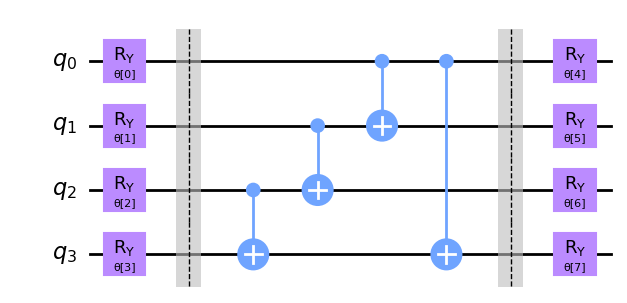

Ansatz 2:


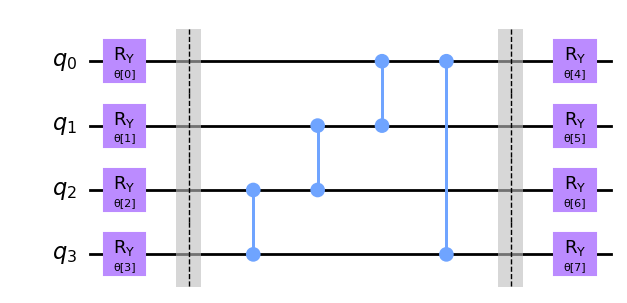

Ansatz 3:


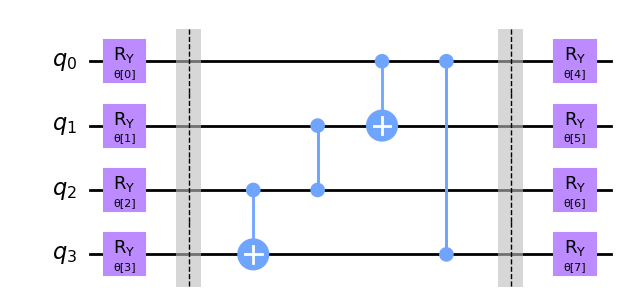

Ansatz 4:


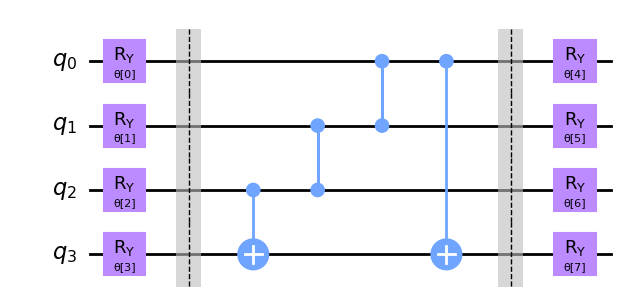

Ansatz 5:


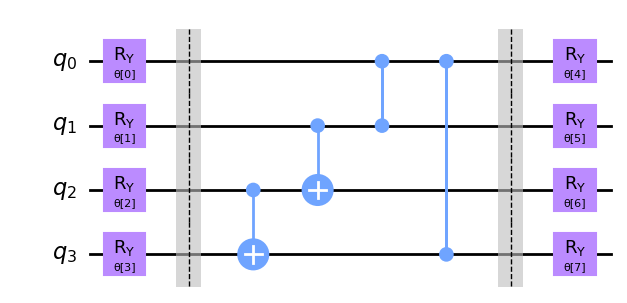

Ansatz 6:


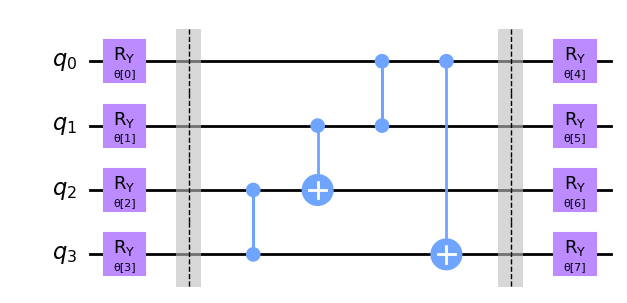

Ansatz 7:


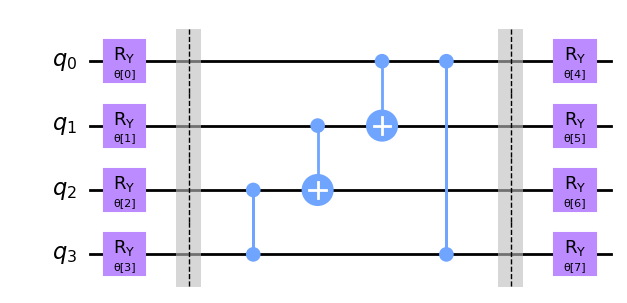

Ansatz 8:


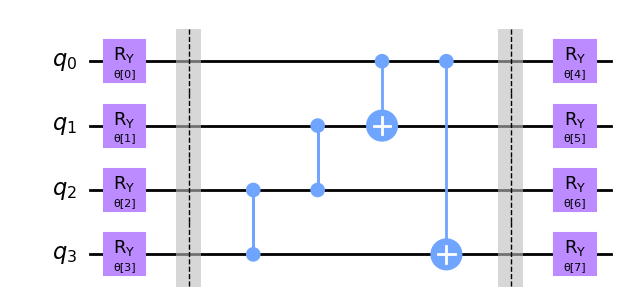

Ansatz 9:


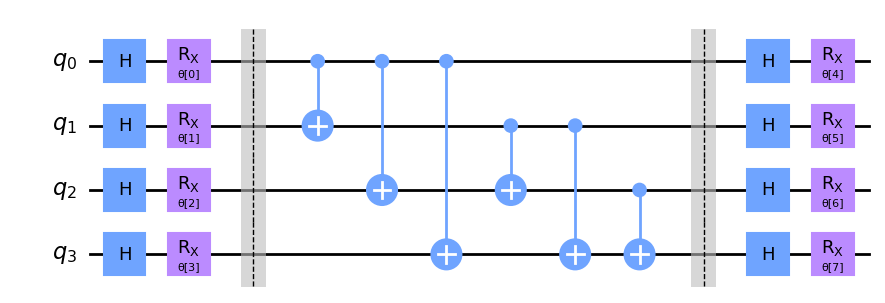

Ansatz 10:


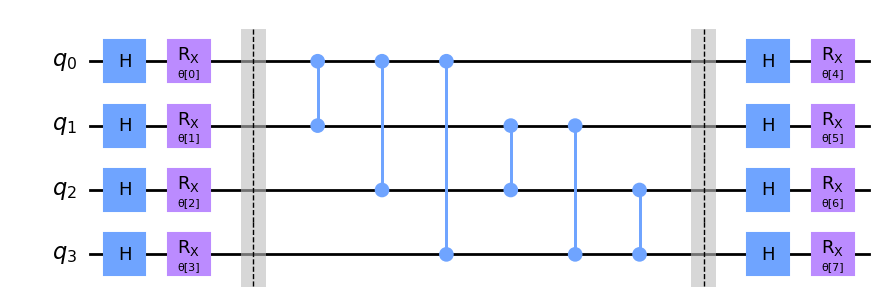

Ansatz 11:


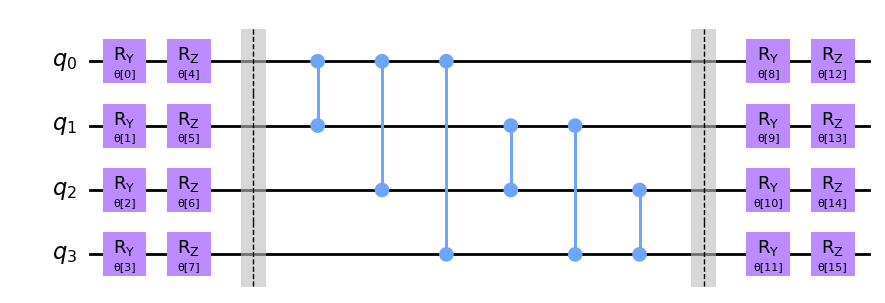

Ansatz 12:


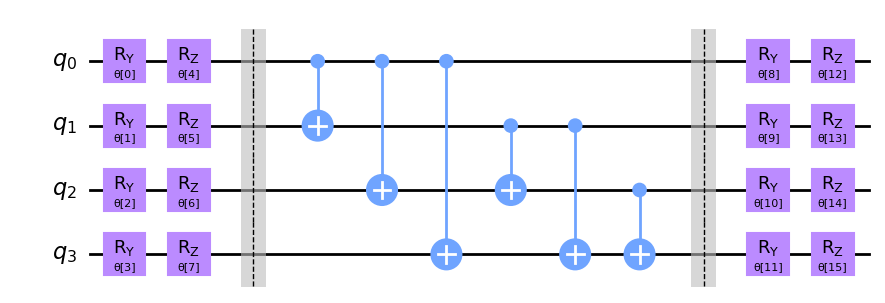

Ansatz 13:


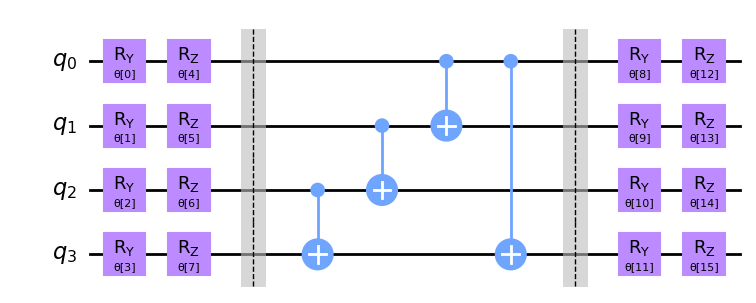

Ansatz 14:


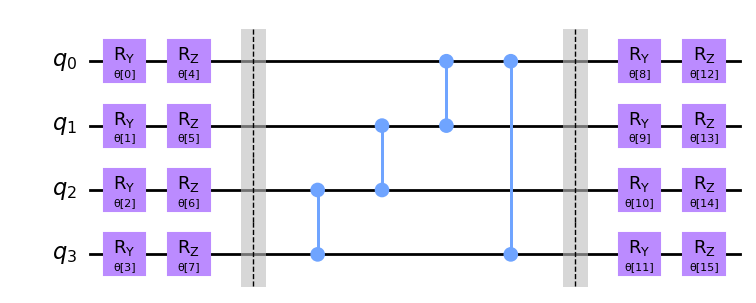

Ansatz 15:


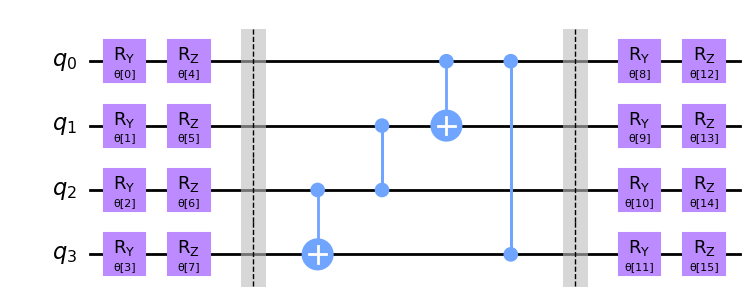

Ansatz 16:


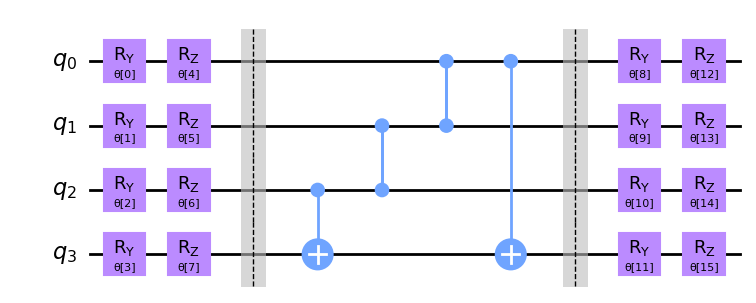

Ansatz 17:


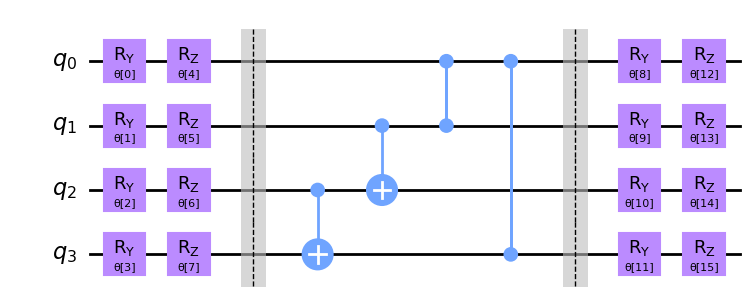

Ansatz 18:


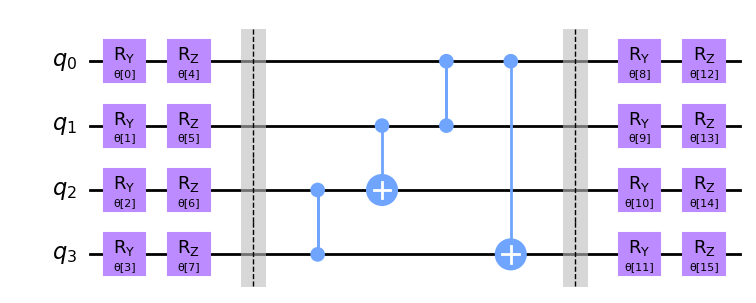

Ansatz 19:


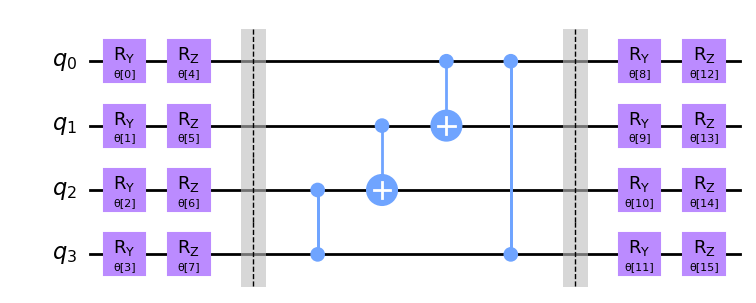

Ansatz 20:


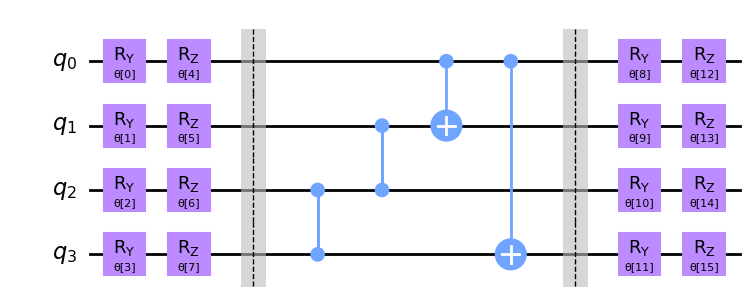

Ansatz 21:


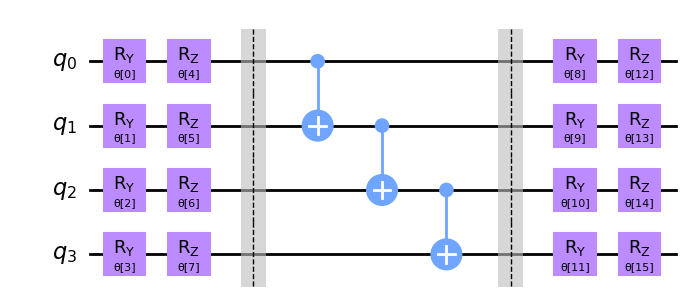

Ansatz 22:


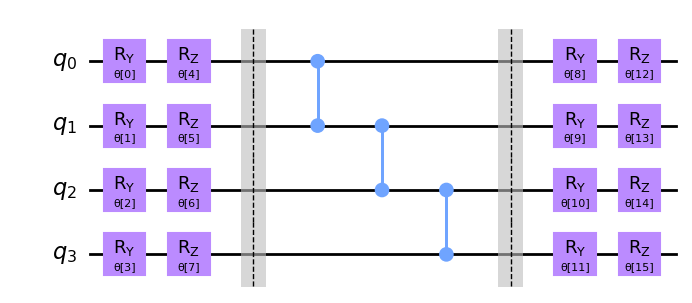

Ansatz 23:


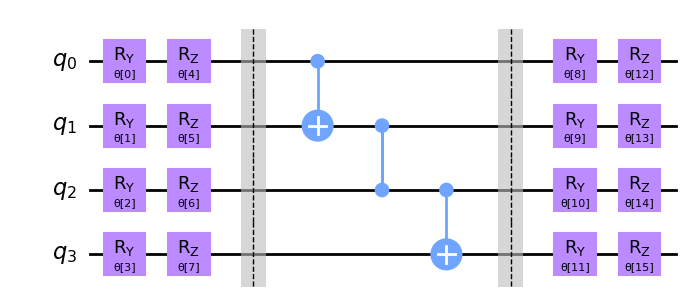

Ansatz 24:


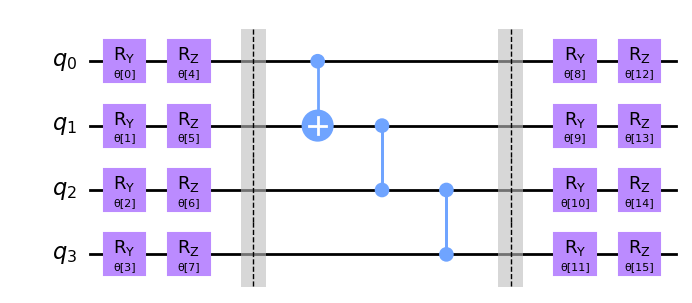

Ansatz 25:


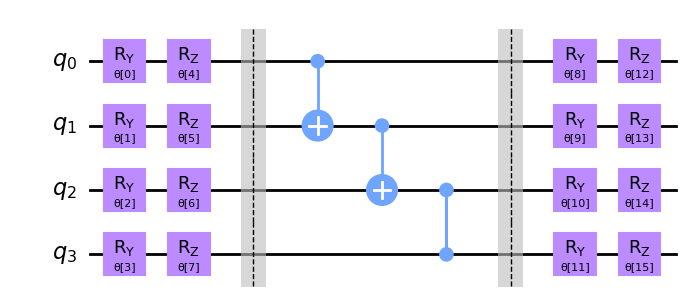

Ansatz 26:


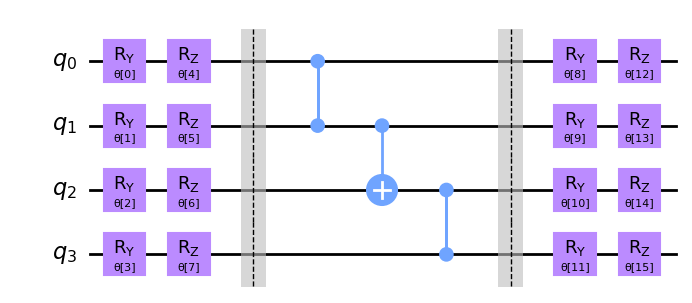

Ansatz 27:


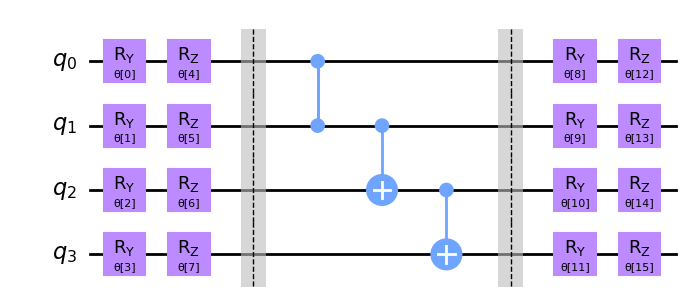

Ansatz 28:


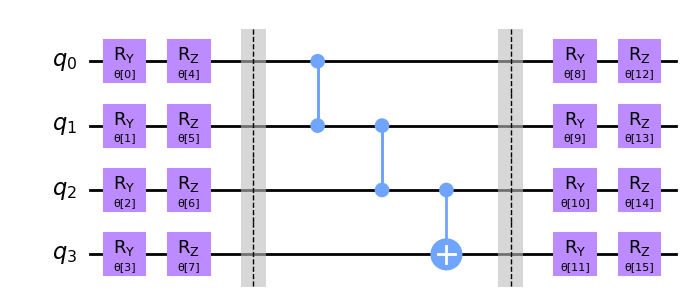

Ansatz 29:


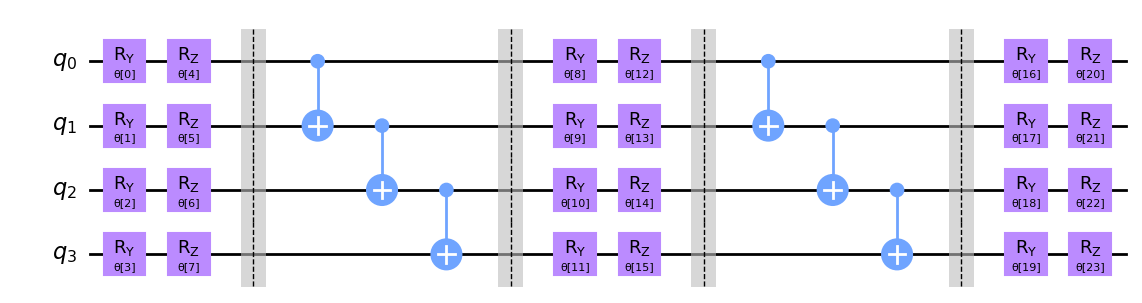

Ansatz 30:


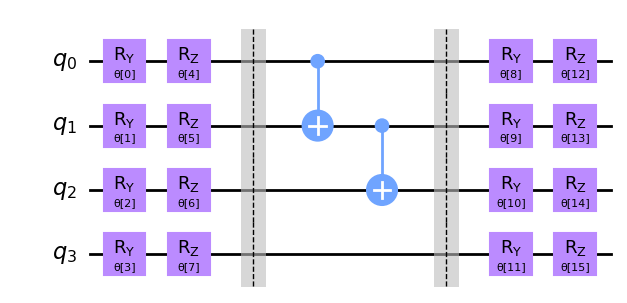

Ansatz 31:


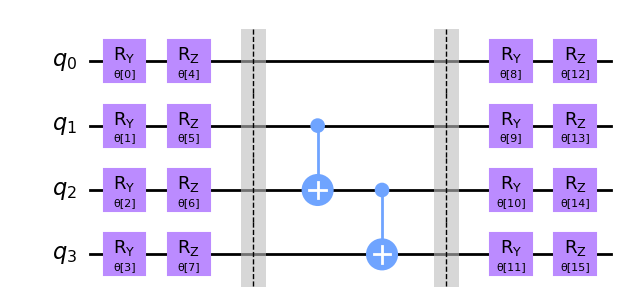

Ansatz 32:


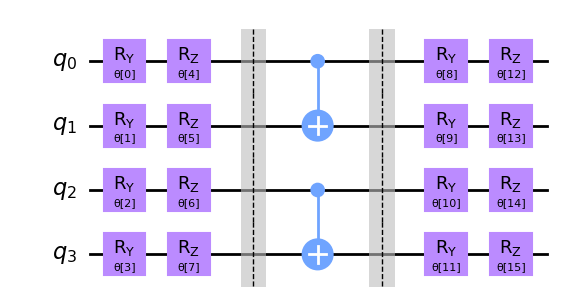

In [8]:
# It is also an option to provide a list of integers as an arg, in order to obtain specific circuits
exp_1.circuits_repr()